<a href="https://colab.research.google.com/github/poponzu/Research/blob/master/%5Btest%E6%90%8D%E5%A4%B1%E8%BF%BD%E5%8A%A0%5D%5B15%E7%89%B9%E5%BE%B4%E9%87%8F%5DLSTM%E8%A4%87%E6%95%B0%E5%85%A5%E5%8A%9B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  <span style="color: red">実行前にデバッグモードであるかどうか、train_start, test_start, data_endの値, 学習回数epochsを確認！</span>

In [284]:
# debug = 1はデバック（動作確認用)
debug = 0

In [285]:
# データの範囲指定
if debug:
  train_start = 2000
  test_start = 2490
  data_end = 2500
else: 
  # train_start = 2000
  train_start = 0
  # test_start = 6500
  test_start = 10512+2629
  # data_end = 7000
  data_end = 17379

# 学習回数
if debug:
  epochs = 2
else:
  epochs = 25

In [286]:
10512+2629+4238

17379

## このノートブックのLSTMモデルは[これ](https://qiita.com/tsubauaaa/items/8411a22465811ec2ee11#%E5%AD%A6%E7%BF%92%E3%83%87%E3%83%BC%E3%82%BF%E3%81%AE%E3%82%B7%E3%83%BC%E3%82%B1%E3%83%B3%E3%82%B9%E3%83%87%E3%83%BC%E3%82%BF%E3%82%92%E5%8F%96%E5%BE%97)を参考に作成した！

In [287]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [288]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from torchmetrics.functional import mean_absolute_error
import random
import os
%matplotlib inline

In [289]:
# deviceの作成
# device = 'cuda' if torch.cuda.is_available else 'cpu'
device = 'cpu'

In [290]:
device

'cpu'

In [291]:
# Google Driveをマウントする
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [292]:
def seed_everything(seed=42):
    print('Setting Random Seed')
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(42)

Setting Random Seed


In [293]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LSTM-AE/Bike_sharing_predict/Bike-Sharing-Dataset/hour.csv")

In [294]:
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [295]:
len_data = data.shape[0]

# 使用する特徴量を指定する

In [296]:
Bike_data = data[['cnt','season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered']]

# 特徴量を時系列にグラフ表示

In [297]:
# fig, (axL, axM, axR) = plt.subplots(ncols=3, figsize=(20,5))

# axL.plot(Bike_data['cnt'], linewidth=2)
# axL.set_title('Number of Bike sharing cnt')
# axL.set_xlabel('2012/1/1-2013/12/31')
# axL.set_ylabel('cnt')
# axL.grid(True)
# axL.vlines(x=2000, ymin=0, ymax=1000, colors='red', linestyles='dotted')
# axL.vlines(x=6500, ymin=0, ymax=1000, colors='black', linestyles='dotted')
# axL.vlines(x=7000, ymin=0, ymax=1000, colors='red', linestyles='dotted')


# axM.plot(Bike_data['temp'], linewidth=2)
# axM.set_title('tempeture')
# axM.set_xlabel('2012/1/1-2013/12/31')
# axM.set_ylabel('temp')
# axM.grid(True)
# axM.vlines(x=2000, ymin=0, ymax=1, colors='red', linestyles='dotted')
# axM.vlines(x=6500, ymin=0, ymax=1, colors='black', linestyles='dotted')
# axM.vlines(x=7000, ymin=0, ymax=1, colors='red', linestyles='dotted')

# axR.plot(Bike_data['registered'], linewidth=2)
# axR.set_title('Number of registered')
# axR.set_xlabel('2012/1/1-2013/12/31')
# axR.set_ylabel('registered')
# axR.grid(True)
# axR.vlines(x=2000, ymin=0, ymax=800, colors='red', linestyles='dotted')
# axR.vlines(x=6500, ymin=0, ymax=800, colors='black', linestyles='dotted')
# axR.vlines(x=7000, ymin=0, ymax=800, colors='red', linestyles='dotted')

# fig.show()

# 軽量化のためデータ量を調節

In [298]:
Bike_data = Bike_data[train_start:data_end]

In [299]:
Bike_data = Bike_data.values.astype(float)
Bike_data.shape

(17379, 15)

# 学習データとテストデータに分割する

In [300]:
test_data_size = data_end - test_start

train_data = Bike_data[:-test_data_size]
test_data = Bike_data[-test_data_size:]

In [301]:
#train_dataの正規化
# データセットの正規化を行う。最小値0と最大値1の範囲で行う。
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
train_data_normalized = scaler.fit_transform(train_data)

In [302]:
# Tensor型に変換
train_data_normalized = torch.FloatTensor(train_data_normalized)

In [303]:
# シーケンスに沿ったデータを作成する関数
def make_sequence_data(input_data, num_sequence):
    # シーケンスデータとラベルデータの器
    data = []
    # 全体のデータ数取得
    num_data = len(input_data)
    # 全体からシーケンス分引いた数までループする
    for i in range(num_data - num_sequence):
        # 1個ずらして、シーケンス分のデータを取得していく
        seq_data = input_data[i:i+num_sequence]
        # シーケンスの次の要素のデータ(ラベルデータとして1個目の陽性者数のみ)を取得していく
        target_data = input_data[:,0][i+num_sequence:i+num_sequence+1]
        # シーケンスデータとラベルデータをタプルとして取得していく
        data.append((seq_data, target_data))

    return data

In [304]:
# シーケンス長は24データとする
# 24時間分のデータから次の1日後のデータを予測する
# 48時間とかにしてもよいかも
seq_length = 24
# train_seq_data=最初のデータを1個ずらしてシーケンス分のデータ(時系列の学習データ群)、train_target=train_seq_dataの次のデータ(ラベルデータ)
train_seq_data = make_sequence_data(train_data_normalized, seq_length)

In [305]:
train_data_normalized[:3]

tensor([[0.0157, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
         0.2292, 0.2879, 0.8100, 0.0000, 0.0082, 0.0163],
        [0.0408, 0.0000, 0.0000, 0.0000, 0.0435, 0.0000, 1.0000, 0.0000, 0.0000,
         0.2083, 0.2727, 0.8000, 0.0000, 0.0218, 0.0402],
        [0.0324, 0.0000, 0.0000, 0.0000, 0.0870, 0.0000, 1.0000, 0.0000, 0.0000,
         0.2083, 0.2727, 0.8000, 0.0000, 0.0136, 0.0339]])

In [306]:
# train_seq_data[:3]

In [307]:
class LSTM(nn.Module):
    def __init__(self, input_size=15, hidden_layer_size=100, output_size=1, num_layers=2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_layer_size, num_layers=num_layers, batch_first=True, dropout=0.1)

        self.linear = nn.Linear(in_features=hidden_layer_size, out_features=output_size)

    def forward(self, x):
        # LSTMのinputは(batch_size, seq_len, input_size)にする
        # LSTMのoutputは(batch_size, seq_len, hidden_layer_size)となる
        # hidden stateとcell stateにはNoneを渡して0ベクトルを渡す
        lstm_out, (hn, cn) = self.lstm(x, None)
        # Linearのinputは(N,∗,in_features)にする
        # lstm_out(batch_size, seq_len, hidden_layer_size)のseq_len方向の最後の値をLinearに入力する
        prediction = self.linear(lstm_out[:, -1, :])
        return prediction

In [308]:
device

'cpu'

In [309]:
device = 'cpu'

In [310]:
model = LSTM()
model.to(device)

LSTM(
  (lstm): LSTM(15, 100, num_layers=2, batch_first=True, dropout=0.1)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [311]:
# 損失関数と最適化関数を定義
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# testの損失も追加する

In [312]:
# 予測する日数
pred_days = test_data_size
# テストデータの正規化を行う。最小値0と最大値1の範囲で行ってTensor型に変換する。
test_data_normalized = scaler.fit_transform(test_data)
test_data_normalized = torch.FloatTensor(test_data_normalized)
# 予測するためのデータの最初のseq_length分はtrain_dataを使う
test_inputs = train_data_normalized[-seq_length:].tolist()

# t_dataの用意
t_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LSTM-AE/Bike_sharing_predict/Bike-Sharing-Dataset/hour.csv")
t_data = t_data["cnt"][test_start:data_end]
t_data = t_data.values.astype(np.float32)
t_data = torch.from_numpy(t_data)

In [313]:
import tqdm

train_losses = []
test_losses = []

for epoch in tqdm.tqdm(range(epochs)):
    model.train()
    for seq, labels in train_seq_data:
        # seq, labelsのshapeは(seq_length, 特徴量)なのでLSTMに渡すために(batch, seq_length, 特徴量)にする。(batch=1)
        seq, labels = torch.unsqueeze(seq, 0), torch.unsqueeze(labels, 0)
        seq, labels = seq.to(device), labels.to(device)
        optimizer.zero_grad()
        y_pred = model(seq)
        single_loss = criterion(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    train_losses.append(single_loss.item())
    # print(f'epoch: {i}, train_loss : {single_loss.item()}')

    # testデータに対する予測の損失計算
    # モデルを評価モードとする
    model.eval()
    # 予測値を入れるリスト
    test_outputs = []
    for i in range(pred_days):
        seq = torch.FloatTensor(test_inputs[-seq_length:])
        seq = torch.unsqueeze(seq, 0)
        seq = seq.to(device)
        with torch.no_grad():
            test_inputs.append(test_data_normalized.tolist()[i])
            test_outputs.append(model(seq).item())

    np_test_outputs = np.array(test_outputs).reshape(-1,1)
    # 列方向に同じ値を追加して(?, 15)にする
    np_test_outputs2 = np.hstack((np_test_outputs, np_test_outputs))
    np_test_outputs3 = np.hstack((np_test_outputs2, np_test_outputs))
    np_test_outputs4 = np.hstack((np_test_outputs3, np_test_outputs))
    np_test_outputs5 = np.hstack((np_test_outputs4, np_test_outputs))
    np_test_outputs6 = np.hstack((np_test_outputs5, np_test_outputs))
    np_test_outputs7 = np.hstack((np_test_outputs6, np_test_outputs))
    np_test_outputs8 = np.hstack((np_test_outputs7, np_test_outputs))
    np_test_outputs9 = np.hstack((np_test_outputs8, np_test_outputs))
    np_test_outputs10 = np.hstack((np_test_outputs9, np_test_outputs))
    np_test_outputs11 = np.hstack((np_test_outputs10, np_test_outputs))
    np_test_outputs12 = np.hstack((np_test_outputs11, np_test_outputs))
    np_test_outputs13 = np.hstack((np_test_outputs12, np_test_outputs))
    np_test_outputs14 = np.hstack((np_test_outputs13, np_test_outputs))
    np_test_outputs15 = np.hstack((np_test_outputs14, np_test_outputs))

    actual_predictions = scaler.inverse_transform(np_test_outputs15)


    predictions = torch.from_numpy(actual_predictions[:,0])
    test_criterion = nn.MSELoss()
    test_loss = test_criterion(t_data, predictions)
    print(f'epoch: {epoch}, train_loss : {single_loss.item()}, test_loss : {test_loss}')
    test_losses.append(test_loss)

  4%|▍         | 1/25 [03:11<1:16:47, 191.99s/it]

epoch: 0, train_loss : 0.00010736547119449824, test_loss : 6228.165961278974


  8%|▊         | 2/25 [06:15<1:11:42, 187.07s/it]

epoch: 1, train_loss : 0.0031073661521077156, test_loss : 5004.973146653054


 12%|█▏        | 3/25 [09:26<1:09:11, 188.71s/it]

epoch: 2, train_loss : 0.005945491138845682, test_loss : 5127.0242646768975


 16%|█▌        | 4/25 [12:41<1:06:57, 191.30s/it]

epoch: 3, train_loss : 0.003179259365424514, test_loss : 5623.622784402685


 20%|██        | 5/25 [15:56<1:04:10, 192.54s/it]

epoch: 4, train_loss : 0.0032104903366416693, test_loss : 6278.766206165094


 24%|██▍       | 6/25 [19:10<1:01:06, 192.97s/it]

epoch: 5, train_loss : 2.0091272745048627e-05, test_loss : 5589.644085228475


 28%|██▊       | 7/25 [22:23<57:53, 192.95s/it]  

epoch: 6, train_loss : 0.005123405251652002, test_loss : 6062.930269657777


 32%|███▏      | 8/25 [25:34<54:31, 192.42s/it]

epoch: 7, train_loss : 0.002762544434517622, test_loss : 5713.54432267769


 36%|███▌      | 9/25 [28:44<51:08, 191.76s/it]

epoch: 8, train_loss : 0.0035099617671221495, test_loss : 4809.716813204405


 40%|████      | 10/25 [31:53<47:43, 190.91s/it]

epoch: 9, train_loss : 0.0040321652777493, test_loss : 5461.2609988816375


 44%|████▍     | 11/25 [35:02<44:26, 190.44s/it]

epoch: 10, train_loss : 0.0006100510363467038, test_loss : 5322.198487068002


 48%|████▊     | 12/25 [38:11<41:09, 189.98s/it]

epoch: 11, train_loss : 0.009514881297945976, test_loss : 4849.8088975861


 52%|█████▏    | 13/25 [41:22<38:02, 190.24s/it]

epoch: 12, train_loss : 0.0014278409071266651, test_loss : 4609.6954468208705


 56%|█████▌    | 14/25 [44:32<34:50, 190.02s/it]

epoch: 13, train_loss : 0.0068428716622292995, test_loss : 4407.000911396775


 60%|██████    | 15/25 [47:42<31:39, 189.96s/it]

epoch: 14, train_loss : 0.008200123906135559, test_loss : 4536.773070439773


 64%|██████▍   | 16/25 [50:50<28:25, 189.53s/it]

epoch: 15, train_loss : 0.0022149309515953064, test_loss : 5412.613998740295


 68%|██████▊   | 17/25 [53:56<25:07, 188.39s/it]

epoch: 16, train_loss : 0.002580557717010379, test_loss : 5259.729077484803


 72%|███████▏  | 18/25 [57:00<21:50, 187.22s/it]

epoch: 17, train_loss : 0.0015273367753252387, test_loss : 5237.79836731262


 76%|███████▌  | 19/25 [1:00:03<18:35, 185.99s/it]

epoch: 18, train_loss : 0.003898788010701537, test_loss : 4180.30763741657


 80%|████████  | 20/25 [1:03:07<15:26, 185.36s/it]

epoch: 19, train_loss : 0.01025679986923933, test_loss : 4775.674581329239


 84%|████████▍ | 21/25 [1:06:13<12:21, 185.35s/it]

epoch: 20, train_loss : 0.011240007355809212, test_loss : 4866.003360655015


 88%|████████▊ | 22/25 [1:09:19<09:16, 185.52s/it]

epoch: 21, train_loss : 0.009810923598706722, test_loss : 4597.807905267408


 92%|█████████▏| 23/25 [1:12:23<06:10, 185.29s/it]

epoch: 22, train_loss : 0.01615987718105316, test_loss : 4832.171761112764


 96%|█████████▌| 24/25 [1:15:29<03:05, 185.54s/it]

epoch: 23, train_loss : 0.030357519164681435, test_loss : 3989.180256508873


100%|██████████| 25/25 [1:18:34<00:00, 188.60s/it]

epoch: 24, train_loss : 0.006658843718469143, test_loss : 4347.864549744812


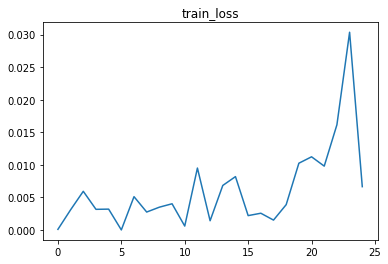

In [314]:
#trainデータに対する予測の損失をグラフ表示
plt.title('train_loss')
plt.plot(train_losses)

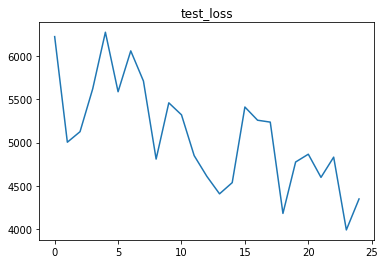

In [315]:
# testデータに対する予測の損失をグラフ表示
plt.title('test_loss')
plt.plot(test_losses)

In [316]:
# 予測する日数
pred_days = test_data_size
# テストデータの正規化を行う。最小値0と最大値1の範囲で行ってTensor型に変換する。
test_data_normalized = scaler.fit_transform(test_data)
test_data_normalized = torch.FloatTensor(test_data_normalized)
# 予測するためのデータの最初のseq_length分はtrain_dataを使う
test_inputs = train_data_normalized[-seq_length:].tolist()

In [317]:
seq_length

24

In [318]:
# モデルを評価モードとする
model.eval()
# 予測値を入れるリスト
test_outputs = []
for i in tqdm.tqdm(range(pred_days)):
    seq = torch.FloatTensor(test_inputs[-seq_length:])
    seq = torch.unsqueeze(seq, 0)
    seq = seq.to(device)
    with torch.no_grad():
        test_inputs.append(test_data_normalized.tolist()[i])
        test_outputs.append(model(seq).item())

100%|██████████| 4238/4238 [00:26<00:00, 160.52it/s]


#  出力結果を入力の列に使った特徴量の次元に合わせてここは変更する必要あり。(関数化したいけど、あとで）

In [319]:
np_test_outputs = np.array(test_outputs).reshape(-1,1)
# 列方向に同じ値を追加して(-1, 15)にする
np_test_outputs2 = np.hstack((np_test_outputs, np_test_outputs))
np_test_outputs3 = np.hstack((np_test_outputs2, np_test_outputs))
np_test_outputs4 = np.hstack((np_test_outputs3, np_test_outputs))
np_test_outputs5 = np.hstack((np_test_outputs4, np_test_outputs))
np_test_outputs6 = np.hstack((np_test_outputs5, np_test_outputs))
np_test_outputs7 = np.hstack((np_test_outputs6, np_test_outputs))
np_test_outputs8 = np.hstack((np_test_outputs7, np_test_outputs))
np_test_outputs9 = np.hstack((np_test_outputs8, np_test_outputs))
np_test_outputs10 = np.hstack((np_test_outputs9, np_test_outputs))
np_test_outputs11 = np.hstack((np_test_outputs10, np_test_outputs))
np_test_outputs12 = np.hstack((np_test_outputs11, np_test_outputs))
np_test_outputs13 = np.hstack((np_test_outputs12, np_test_outputs))
np_test_outputs14 = np.hstack((np_test_outputs13, np_test_outputs))
np_test_outputs15 = np.hstack((np_test_outputs14, np_test_outputs))

actual_predictions = scaler.inverse_transform(np_test_outputs15)

In [320]:
# 関数化を試みるも面倒(10/5時点)
def stack(outputs, dim):
  np_outputs1 = np.array(outputs).reshape(-1,1)

In [321]:
test_data_size

4238

In [322]:
# 予測値のx軸の値の設定
x = np.arange(test_start, data_end, 1)
print(x,test_data_size)

[13141 13142 13143 ... 17376 17377 17378] 4238


# 予測結果と実際の値を同じ図に図示する

In [323]:
fig_size = plt.rcParams['figure.figsize']
fig_size[0] = 10
fig_size[1] = 5
plt.rcParams['figure.figsize'] = fig_size

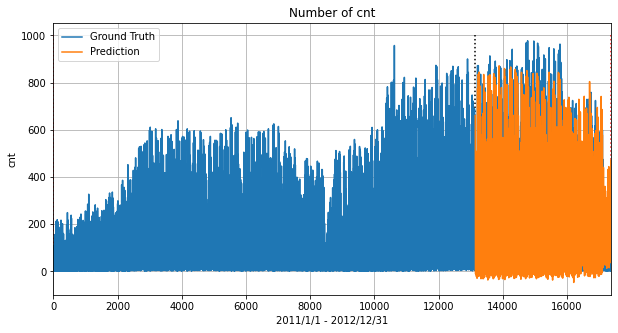

In [324]:
plt.title('Number of cnt')
plt.ylabel('cnt')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(data['cnt'], label='Ground Truth')
plt.plot(x, actual_predictions[:,0], label='Prediction')
plt.xlabel('2011/1/1 - 2012/12/31')
plt.legend()
plt.vlines(x=train_start, ymin=0, ymax=1000, colors='red', linestyles='dotted')
plt.vlines(x=test_start, ymin=0, ymax=1000, colors='black', linestyles='dotted')
plt.vlines(x=data_end, ymin=0, ymax=1000, colors='red', linestyles='dotted')
plt.show()

# 予測部分拡大ver

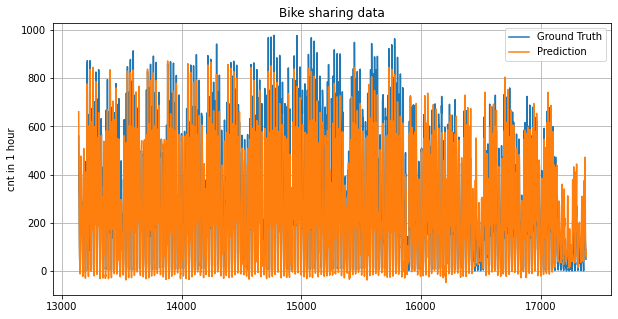

In [325]:
plt.title('Bike sharing data')
plt.ylabel('cnt in 1 hour')
plt.grid(True)
plt.plot(data["cnt"][test_start:data_end], label='Ground Truth')
plt.plot(x,actual_predictions[:,0], label='Prediction')
plt.legend()
plt.show()

## 考察
# 日毎のデータでもLSTMモデル立ててもいいかも

## 損失の値を出す

In [326]:
t_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LSTM-AE/Bike_sharing_predict/Bike-Sharing-Dataset/hour.csv")
t_data = t_data["cnt"][test_start:data_end]
t_data = t_data.values.astype(np.float32)
t_data = torch.from_numpy(t_data)
predicitions = torch.from_numpy(actual_predictions[:,0])

MSE_criterion = nn.MSELoss()
MSE_loss = MSE_criterion(t_data, predictions)

MAE_loss =  mean_absolute_error(t_data, predictions)

print(f'MSEの値は: {MSE_loss} です')
print(f'RMSEの値は: {torch.sqrt(MSE_loss)} です')
print(f'MAEの値は: {MAE_loss} です')

MSEの値は: 4347.864549744812 です
RMSEの値は: 65.9383389974665 です
MAEの値は: 48.011172949564575 です


In [327]:
len(t_data)

4238

In [328]:
len(predictions)

4238